Installing all the dependencies

In [13]:
!pip install pandas
!pip install rdkit
!pip install xgboost
!pip install scikit-learn
!pip install numpy
!pip install matplotlib  # Optional


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 54.6 MB/s eta 0:00:00


Uploading the dataset

In [7]:
from google.colab import files
uploaded = files.upload()

Saving 250k_rndm_zinc_drugs_clean_3.csv.zip to 250k_rndm_zinc_drugs_clean_3.csv.zip


Extracting the zip file

In [10]:
import pandas as pd
import zipfile
import os

# Extract the uploaded file (if the name is correct)
zip_file_path = '/content/250k_rndm_zinc_drugs_clean_3.csv.zip'
extract_folder = '/content/extracted_data/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the extracted files
extracted_files = os.listdir(extract_folder)
print(f"Extracted files: {extracted_files}")

# Load the extracted CSV
csv_file_path = os.path.join(extract_folder, '250k_rndm_zinc_drugs_clean_3.csv')
df = pd.read_csv('/content/extracted_data/250k_rndm_zinc_drugs_clean_3.csv')

# Display the first few rows
print(df.head())


Extracted files: ['250k_rndm_zinc_drugs_clean_3.csv']
                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


Checking the data

In [11]:
import pandas as pd

# Load the dataset from the extracted folder
csv_file_path = '/content/extracted_data/250k_rndm_zinc_drugs_clean_3.csv'
df = pd.read_csv(csv_file_path)

# Display the first few rows to understand the structure
print(df.columns)  # Check column names
print(df.head())  # View first few rows


Index(['smiles', 'logP', 'qed', 'SAS'], dtype='object')
                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


SMILES Cleaning function

In [15]:
from rdkit import Chem
from rdkit.Chem import SaltRemover

# SMILES cleaning function
def clean_smiles(df, smiles_col='smiles'):
    """Standardize SMILES and remove salts"""
    remover = SaltRemover.SaltRemover()

    def process_smiles(smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            mol = remover.StripMol(mol, dontRemoveEverything=True)
            return Chem.MolToSmiles(mol, isomericSmiles=True)
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {e}")
            return None

    df['clean_smiles'] = df[smiles_col].apply(process_smiles)
    df = df.dropna(subset=['clean_smiles']).reset_index(drop=True)
    return df

# Apply SMILES cleaning
df = clean_smiles(df)

# Check the cleaned data
print(df.head())


                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS                                       clean_smiles  
0  2.084095            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  
1  3.432004       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  
2  2.470633  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  
3  2.822753  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  
4  4.035182  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  


Decriptor Calculation

In [16]:
from rdkit.Chem import Descriptors, Lipinski

# Descriptor calculation function
def calculate_descriptors(df):
    """Compute physicochemical properties"""
    def get_descriptors(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return {
                'logP': Descriptors.MolLogP(mol),
                'MW': Descriptors.MolWt(mol),
                'HBD': Lipinski.NumHDonors(mol),
                'HBA': Lipinski.NumHAcceptors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'RotatableBonds': Lipinski.NumRotatableBonds(mol),
                'AromaticRings': Lipinski.NumAromaticRings(mol),
                'HeavyAtoms': Lipinski.HeavyAtomCount(mol),
                'Charge': Descriptors.NumRadicalElectrons(mol),
                'RingCount': Lipinski.RingCount(mol),
                'FractionCSP3': Lipinski.FractionCSP3(mol),
                'HallKierAlpha': Descriptors.HallKierAlpha(mol),
                'ValenceElectrons': Descriptors.NumValenceElectrons(mol),
                'SMR': Descriptors.MolMR(mol),
                'QED': Descriptors.qed(mol)
            }
        else:
            return {key: None for key in ['logP', 'MW', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms', 'Charge', 'RingCount', 'FractionCSP3', 'HallKierAlpha', 'ValenceElectrons', 'SMR', 'QED']}

    descriptor_df = df['clean_smiles'].apply(lambda x: pd.Series(get_descriptors(x)))
    return pd.concat([df, descriptor_df], axis=1)

# Apply descriptor calculation
df = calculate_descriptors(df)

# Check the data with the descriptors
print(df.head())


                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS                                       clean_smiles     logP  \
0  2.084095            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  5.05060   
1  3.432004       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  3.11370   
2  2.470633  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778   
3  2.822753  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022   
4  4.035182  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956   

        MW  HBD  HBA    TPSA  RotatableBonds  AromaticRings  HeavyAtoms  \
0  325.383  1.0  2.0   

Checking if the columns are correct or not

In [17]:
# Check column names and first few rows of the DataFrame
print(df.columns)  # Print column names
print(df.head())    # View the first few rows of the cleaned dataset


Index(['smiles', 'logP', 'qed', 'SAS', 'clean_smiles', 'logP', 'MW', 'HBD',
       'HBA', 'TPSA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms',
       'Charge', 'RingCount', 'FractionCSP3', 'HallKierAlpha',
       'ValenceElectrons', 'SMR', 'QED'],
      dtype='object')
                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS                                       clean_smiles     logP  \
0  2.084095            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  5.05060   
1  3.432004       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  3.11370   
2  2.470633  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)

Defining the output column 'drug like'

In [20]:
# Check column names to see if there are duplicates
print(df.columns)

# If there are duplicates, remove them
df = df.loc[:, ~df.columns.duplicated()]

# Create the 'drug_like' column based on Lipinski's Rule of Five
df['drug_like'] = (
    (df['MW'] <= 500) &
    (df['logP'] <= 5) &
    (df['HBD'] <= 5) &
    (df['HBA'] <= 10)
).astype(int)

# Check the distribution of the 'drug_like' column
print(df['drug_like'].value_counts())


Index(['smiles', 'logP', 'qed', 'SAS', 'clean_smiles', 'logP', 'MW', 'HBD',
       'HBA', 'TPSA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms',
       'Charge', 'RingCount', 'FractionCSP3', 'HallKierAlpha',
       'ValenceElectrons', 'SMR', 'QED'],
      dtype='object')
drug_like
1    245433
0      4022
Name: count, dtype: int64


Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[['logP', 'QED', 'SAS', 'MW', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms', 'Charge', 'RingCount', 'FractionCSP3', 'HallKierAlpha', 'ValenceElectrons', 'SMR']]
y = df['drug_like']  # Assuming 'drug_like' is your target variable

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (199564, 16)
Validation set: (24945, 16)
Test set: (24946, 16)


Model Training

In [29]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Create DMatrix objects for core XGBoost API
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # Objective for binary classification
    'eval_metric': 'logloss',       # Evaluation metric
    'eta': 0.01,                    # Learning rate (alias for learning_rate)
    'max_depth': 3,
    'min_child_weight': 5,          # Regularization to prevent overfitting
    'seed': 42                      # Random state (alias for random_state)
}

# Train the model with early stopping using xgb.train()
gb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # A large number, early stopping will stop it
    evals=[(dval, 'validation')],  # Validation set for early stopping
    early_stopping_rounds=10,  # Stop training after 10 rounds of no improvement
    verbose_eval=True  # Print progress
)

# Evaluate the model on the validation set
# For the core API, prediction is done using predict on DMatrix
y_val_pred_proba = gb_model.predict(dval)
y_val_pred = (y_val_pred_proba > 0.5).astype(int) # Convert probabilities to class labels

print("Classification Report (Validation Set) - Gradient Boosting with Regularization (Core API):")
print(classification_report(y_val, y_val_pred))

# Evaluate the model on the test set
y_test_pred_proba = gb_model.predict(dtest)
y_test_pred = (y_test_pred_proba > 0.5).astype(int) # Convert probabilities to class labels

print("Classification Report (Test Set) - Gradient Boosting with Regularization (Core API):")
print(classification_report(y_test, y_test_pred))

[0]	validation-logloss:0.16353
[1]	validation-logloss:0.16113
[2]	validation-logloss:0.15881
[3]	validation-logloss:0.15658
[4]	validation-logloss:0.15441
[5]	validation-logloss:0.15231
[6]	validation-logloss:0.15027
[7]	validation-logloss:0.14828
[8]	validation-logloss:0.14635
[9]	validation-logloss:0.14446
[10]	validation-logloss:0.14261
[11]	validation-logloss:0.14081
[12]	validation-logloss:0.13904
[13]	validation-logloss:0.13731
[14]	validation-logloss:0.13562
[15]	validation-logloss:0.13396
[16]	validation-logloss:0.13233
[17]	validation-logloss:0.13073
[18]	validation-logloss:0.12916
[19]	validation-logloss:0.12762
[20]	validation-logloss:0.12611
[21]	validation-logloss:0.12462
[22]	validation-logloss:0.12315
[23]	validation-logloss:0.12171
[24]	validation-logloss:0.12030
[25]	validation-logloss:0.11890
[26]	validation-logloss:0.11753
[27]	validation-logloss:0.11618
[28]	validation-logloss:0.11485
[29]	validation-logloss:0.11354
[30]	validation-logloss:0.11225
[31]	validation-lo

Cross-Validation check

In [31]:
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb # Import xgboost

# Initialize the XGBoost Classifier (Scikit-learn API)
# Use the same parameters as the core model for consistency,
# but note that early stopping within cross_val_score is not standard.
# cross_val_score will train a new model for each fold.
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # eval_metric is a parameter for the classifier
    eta=0.01,
    max_depth=3,
    min_child_weight=5,
    seed=42,
    use_label_encoder=False # Suppress a deprecation warning
)

# Perform cross-validation using the Scikit-learn API
cv_scores = cross_val_score(xgb_classifier, X, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")
print(f"Standard deviation of CV scores: {np.std(cv_scores)}")

Cross-validation scores: [0.99961917 0.99941873 0.999539   0.99957908 0.99945882]
Mean CV score: 0.9995229600529154
Standard deviation of CV scores: 7.435103321637227e-05


Testing the model

In [32]:
# Predict on the test set
y_test_pred_proba = gb_model.predict(dtest)  # Get the predicted probabilities
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels

# Classification report for the test set
from sklearn.metrics import classification_report
print("Classification Report (Test Set) - Gradient Boosting with Regularization (Core API):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set) - Gradient Boosting with Regularization (Core API):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       402
           1       1.00      1.00      1.00     24544

    accuracy                           1.00     24946
   macro avg       1.00      0.98      0.99     24946
weighted avg       1.00      1.00      1.00     24946



Plotting the confusion matrix

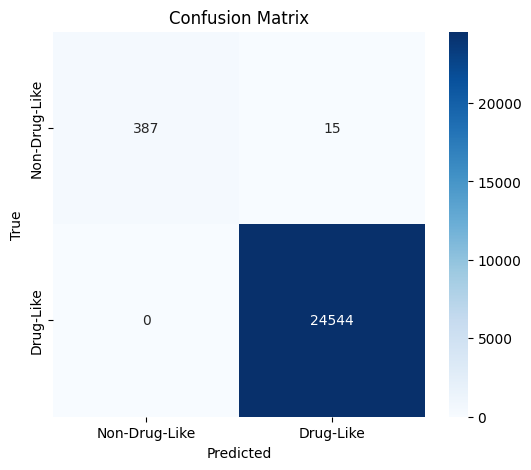

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix on the test set
cm = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Drug-Like", "Drug-Like"], yticklabels=["Non-Drug-Like", "Drug-Like"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Dashboard

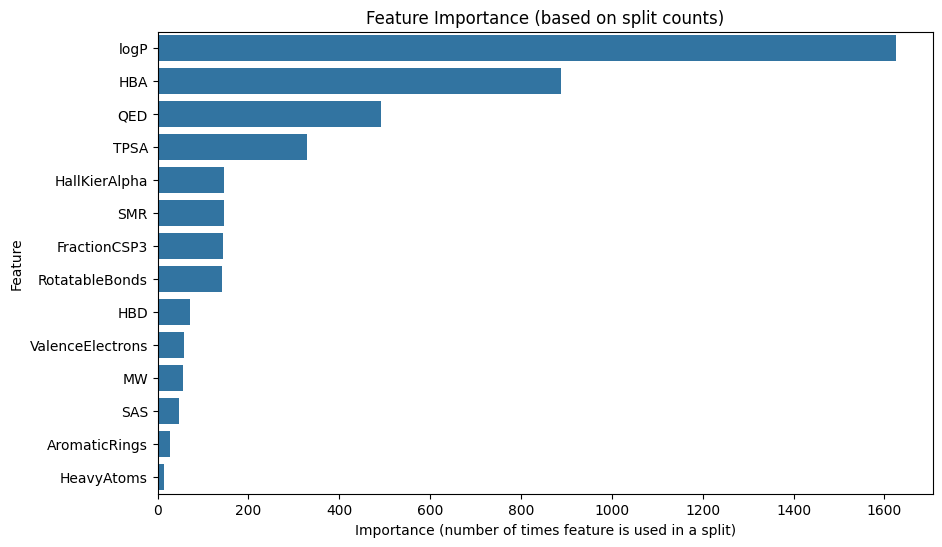

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas

# Get the importance of features from the Booster object
# Use get_score() which returns a dictionary of feature scores
feature_scores = gb_model.get_score(importance_type='weight') # 'weight', 'gain', or 'cover'

# Convert the dictionary to a pandas DataFrame for sorting and plotting
feature_df = pd.DataFrame({
    'feature': list(feature_scores.keys()),
    'importance': list(feature_scores.values())
}).sort_values(by='importance', ascending=False)

# Bar plot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_df)
plt.title('Feature Importance (based on split counts)')
plt.xlabel('Importance (number of times feature is used in a split)')
plt.ylabel('Feature')
plt.show()